In [124]:
import sys, os
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#DWave Credentials
#dwave_solver = "DW_2000Q_2_1"
#api_key = 'DEV-3142f58be13a0aacd44657b15b8fb9832ba3bdac'

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a signed network
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

In [38]:
# Import graph node labels
node_labels = []
with open('CryptoSymbols.csv') as f:
    for line in f.readlines():
        line = line.rstrip() 
        node_labels.append(line)
       
# Import correlation data
corr_matrices = sio.loadmat('P_mat.mat').get('P_mat')

In [131]:
def MakeGraph(corr_mat, node_labels, type='signed'):

    G=nx.Graph()
    G.add_nodes_from(node_labels)
    dim = corr_mat.shape[0]

    if not dim == len(node_labels):
        raise ValueError('number node labels not= corr matrix dimensions')

    if type=='signed':
        for i in range(dim):
            for j in range(i+1, dim):
                if corr_mat[i,j] < 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=-1)
                elif corr_mat[i,j] > 0:
                    G.add_edge(node_labels[i], node_labels[j], sign=1)
    return G        

    STCK  MCAP  SCAP  TRES3`  BOND  TRES20  BOND2  BDMUN  WRLD  WRLD2  EMKT  \
0   0.00  0.98  0.95    0.00  0.00    0.00   0.00   0.00  0.82   0.79  0.67   
1   0.98  0.00  0.97    0.00  0.00    0.00   0.00   0.00  0.88   0.86  0.76   
2   0.95  0.97  0.00   -0.26  0.00   -0.34  -0.28   0.00  0.89   0.89  0.80   
3   0.00  0.00 -0.26    0.00  0.83    0.82   0.68   0.50  0.00   0.00  0.00   
4   0.00  0.00  0.00    0.83  0.00    0.90   0.79   0.67  0.00   0.00  0.00   
5   0.00  0.00 -0.34    0.82  0.90    0.00   0.85   0.66 -0.30  -0.36  0.00   
6   0.00  0.00 -0.28    0.68  0.79    0.85   0.00   0.63 -0.25  -0.34  0.00   
7   0.00  0.00  0.00    0.50  0.67    0.66   0.63   0.00  0.00   0.00  0.00   
8   0.82  0.88  0.89    0.00  0.00   -0.30  -0.25   0.00  0.00   0.99  0.93   
9   0.79  0.86  0.89    0.00  0.00   -0.36  -0.34   0.00  0.99   0.00  0.92   
10  0.67  0.76  0.80    0.00  0.00    0.00   0.00   0.00  0.93   0.92  0.00   
11  0.39  0.36  0.00    0.00  0.52    0.54   0.52   

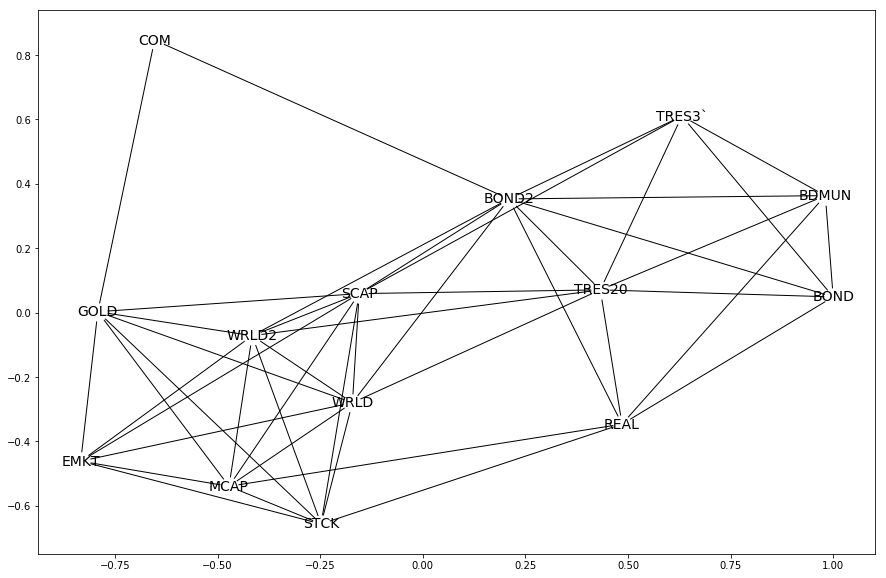

In [135]:
node_labels = ['STCK','MCAP','SCAP','TRES3','BOND','TRES20','BOND2','BDMUN','WRLD','WRLD2','EMKT','REAL','COM','GOLD']
corr_mat_df = pd.read_csv('AssetClasses.csv', header=None, names=node_labels)
corr_mat = corr_mat_df.values

thresh = .25
corr_mat[(corr_mat>-thresh)&(corr_mat<thresh)]=0

G_sign=MakeGraph(corr_mat,node_labels,type='signed')

frustration_array=[]
density_array=[]
density = (2*G_sign.number_of_edges())/(dim*(dim-1))
try:
    imbalance, bicoloring = dnx.structural_imbalance(G_sign, sampler)
    frustration_array.append(len(list(imbalance.keys()))/G_sign.number_of_edges())
    density_array.append(density)
except:
    print(sys.exc_info()[0])


fig, ax = plt.subplots(figsize=(15, 10))
nx.draw_networkx(G_sign,pos=nx.spring_layout(G_sign), font_size=14, node_color='w', ax=ax)


In [147]:
bicoloring

{'STCK': 0,
 'MCAP': 0,
 'SCAP': 0,
 'TRES3`': 1,
 'BOND': 1,
 'TRES20': 1,
 'BOND2': 1,
 'BDMUN': 1,
 'WRLD': 0,
 'WRLD2': 0,
 'EMKT': 0,
 'REAL': 1,
 'COM': 1,
 'GOLD': 0}

In [40]:
# Plot Frustration score over time
frustration_array = []
density_array = []

for i in range(1,2):
    G = nx.Graph()
    G.add_nodes_from(node_labels)
    corr_matrix = corr_matrices

    # Add weighted edges to graph
    for i in range(14):
        for j in range(i+1, 14):
            if corr_matrix[i,j] < 0:
                G.add_edge(node_labels[i], node_labels[j], sign=-1)
            elif corr_matrix[i,j] > 0:
                G.add_edge(node_labels[i], node_labels[j], sign=1)
    
    density = (2*G.number_of_edges())/(14*13)
    
    try:
        imbalance, bicoloring = dnx.structural_imbalance(G, sampler)
        frustration_array.append(len(list(imbalance.keys()))/G.number_of_edges())
        density_array.append(density)
    except:
        print(sys.exc_info()[0])
        print(i)

<class 'RuntimeError'>
26
<class 'RuntimeError'>
26


Text(0.5, 1.0, 'Frustration Score vs Time')

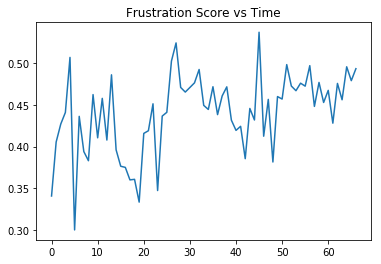

In [41]:


plt.figure(1)
plt.plot(frustration_array)
plt.title("Frustration Score vs Time")

Text(0.5, 1.0, 'Frustration Score vs Graph Density')

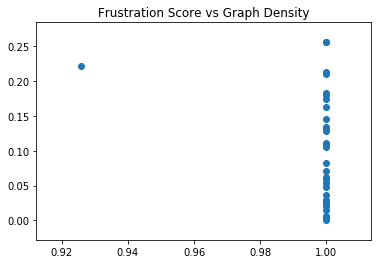

In [22]:
plt.figure(2)
plt.scatter(density_array, frustration_array)
plt.title("Frustration Score vs Graph Density")